### <Center> Лабораторна робота №10. <br> Робота з незбалансованими вибірками

**Спочатку налаштуємо доступ до даних на google drive (якщо ви відкриваєте блокнот в google colab, а не на PC) шляхом монтування google drive**

In [1]:
from google.colab import drive
drive.mount('/content/gdrive') 

Mounted at /content/gdrive


Перевіримо шлях до папки з матеріалами лаборатоної роботи на google drive. Якщо у вас шлях відрізняється то відредагуйте

In [2]:
!ls /content/gdrive/MyDrive/TEACHING/IntroDataScience/intro_to_data_science/Lab_topic_4/

blagging.py
data
img
lab_4.1_credit_scoring_random_forest_eng.ipynb
lab_4.1_credit_scoring_random_forest_eng.pdf
lab_4.1_credit_scoring_random_forest.ipynb
lab_4.1_credit_scoring_random_forest.pdf
lab_4.2_quality_metrics_classification_eng.ipynb
lab_4.2_quality_metrics_classification_eng.pdf
lab_4.2_quality_metrics_classification.ipynb
lab_4.2_quality_metrics_classification.pdf
lab_4.3_xgb_flight_delays_eng.ipynb
lab_4.3_xgb_flight_delays_eng.pdf
lab_4.3_xgb_flight_delays.ipynb
lab_4.3_xgb_flight_delays.pdf
lab_4.4_imbalanced_problems_eng.ipynb
lab_4.4_imbalanced_problems_eng.pdf
lab_4.4_imbalanced_problems.ipynb
lab_4.4_imbalanced_problems.pdf


Перемістимо матеріали лабораторної роботи з google drive на віртуальну машину google colab

In [3]:
!cp -a /content/gdrive/MyDrive/TEACHING/IntroDataScience/intro_to_data_science/Lab_topic_4/. .
!ls

blagging.py
data
gdrive
img
lab_4.1_credit_scoring_random_forest_eng.ipynb
lab_4.1_credit_scoring_random_forest_eng.pdf
lab_4.1_credit_scoring_random_forest.ipynb
lab_4.1_credit_scoring_random_forest.pdf
lab_4.2_quality_metrics_classification_eng.ipynb
lab_4.2_quality_metrics_classification_eng.pdf
lab_4.2_quality_metrics_classification.ipynb
lab_4.2_quality_metrics_classification.pdf
lab_4.3_xgb_flight_delays_eng.ipynb
lab_4.3_xgb_flight_delays_eng.pdf
lab_4.3_xgb_flight_delays.ipynb
lab_4.3_xgb_flight_delays.pdf
lab_4.4_imbalanced_problems_eng.ipynb
lab_4.4_imbalanced_problems_eng.pdf
lab_4.4_imbalanced_problems.ipynb
lab_4.4_imbalanced_problems.pdf
sample_data


## Коротка постановка проблеми

У задачах класифікації баланс класів часто порушується, і зазвичай саме менший клас є цільовим.

Фрод, відмови техніки, позитивні медичні діагнози, небажана видача в пошуковику, відтік - лише частина прикладів таких завдань.

Чому звичайні алгоритми (без шаманства) не дуже добре працюють?

Якщо в загальних рисах, то справа в тому, що всередині багатьох алгоритмів зашита будь-яка оптимізація [loss] (https://en.wikipedia.org/wiki/Loss_function) -функції, часто вже не враховує баланс класів у вибірці. Саме тому модель прагне передбачити якомога ** більше ** об'єктів більшого класу, ігноруючи менший клас, але знижуючи загальний error-rate.

У цій лабораторній роботі ми розглянемо деякі методи, які дозволяють боротися з проблемою нерівних класів.

Як модельний датасет використаємо дані про раздачі в покері (hand), де ознаками є карти (масть -- Suit, ранг -- C), а target -- Poker Hand, тобто різноманітні комбінації наявних карт. Датасет можна скачати [тут](https://archive.ics.uci.edu/ml/datasets/Poker+Hand)

Коротний опис ознак (features) датасету:

```
1) S1 "Suit of card #1" 
Ordinal (1-4) representing {Hearts, Spades, Diamonds, Clubs} 

2) C1 "Rank of card #1" 
Numerical (1-13) representing (Ace, 2, 3, ... , Queen, King
```

Короткий опис цільової мітки (target) для [датасету](https://archive.ics.uci.edu/ml/datasets/Poker+Hand):

```
0: Nothing in hand; not a recognized poker hand
1: One pair; one pair of equal ranks within five cards
2: Two pairs; two pairs of equal ranks within five cards
3: Three of a kind; three equal ranks within five cards
4: Straight; five cards, sequentially ranked with no gaps
5: Flush; five cards with the same suit
6: Full house; pair + different rank three of a kind
7: Four of a kind; four equal ranks within five cards
8: Straight flush; straight + flush
9: Royal flush; {Ace, King, Queen, Jack, Ten} + flush 
```

Чим більша цифра, тим рідше клас і тим виграшніша позиція.

Для прикладів нам знадобиться .py [скрипт](https://github.com/silicon-valley-data-science/learning-from-imbalanced-classes/blob/master/blagging.py) blagging.py, який можно просто покласти поруч рядом с ноутбуком, а также библиотека [imbalanced-learn](http://contrib.scikit-learn.org/imbalanced-learn/index.html):

`pip install -U imbalanced-learn`

In [4]:
!pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 199 kB 5.1 MB/s 
     |████████████████████████████████| 199 kB 53.0 MB/s 
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.8.1
    Uninstalling imbalanced-learn-0.8.1:
      Successfully uninstalled imbalanced-learn-0.8.1


In [1]:
# Завантаження бібліотек

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn import neighbors
from sklearn.metrics import auc, roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.metrics import auc, roc_auc_score, roc_curve, precision_recall_curve
%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.

## Внутрішні параметри алгоритмів для врахування незбалансованості класів


Завантажимо дані і подивимося на них:

In [2]:
def load_and_prepare_data():
    
    # Завантажимо дані і подивимося на них

    df = pd.read_csv('data/poker-hand-training-true.data', 
                     names=['Suit1', 'C1', 'Suit2', 'C2', 'Suit3', 
                            'C3', 'Suit4', 'C4', 'Suit5', 'C5', 'CLASS'])
    
    # кодування порядкових (ordinal) ознак -- окрема тема, тут обійдемося one-hot

    ordinal_columns = [col for col in df.columns if 'Suit' in col]

    ohe = OneHotEncoder(sparse=False)
    encoded_ordinal = ohe.fit_transform(df[ordinal_columns])

    # видаляємо оригінальні колонки
    df.drop(ordinal_columns, axis=1, inplace=True)
    
    tmp = pd.DataFrame(encoded_ordinal, columns=['S ' + str(i) for i in range(encoded_ordinal.shape[1])])
    df = pd.concat([df, tmp], axis=1)
    
    return df

In [3]:
df = load_and_prepare_data()

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:395: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  check_array(X, dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".


In [4]:
df.head(10)

,C1,C2,C3,C4,C5,CLASS,S 0,S 1,S 2,S 3,...,S 10,S 11,S 12,S 13,S 14,S 15,S 16,S 17,S 18,S 19
0,10,11,13,12,1,9,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,11,13,10,12,1,9,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
2,12,11,13,10,1,9,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,10,11,1,13,12,9,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
4,1,13,12,11,10,9,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
5,2,4,5,3,6,8,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
6,9,12,10,11,13,8,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,1,2,3,4,5,8,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
8,5,6,9,7,8,8,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
9,1,4,2,3,5,8,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


Поглянемо на розподіл класів у вибірці, щоб оцінити незбалансованість даних.

In [5]:
# Розподіл класів у вибірці

print("Initial class percentages: \n")
df.CLASS.value_counts()

Initial class percentages: 



0    12493
1    10599
2     1206
3      513
4       93
5       54
6       36
7        6
9        5
8        5
Name: CLASS, dtype: int64

In [6]:
X = df.drop('CLASS', axis=1).values
y = df.CLASS

Подивимося на якість алгоритмів as is, попередньо разбивши дані на train і test.

Під час перегляду метрик рекомендую особливо звертати увагу на `recall` класів чи на F1-міру.

In [7]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    test_size=0.4, random_state=RANDOM_STATE)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note

In [8]:
from sklearn.metrics import classification_report

In [9]:
clf = RandomForestClassifier(random_state=RANDOM_STATE)

clf.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test)))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/forest.py:489: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence t

              precision    recall  f1-score   support

           0       0.55      0.70      0.62      4997
           1       0.48      0.41      0.45      4240
           2       0.10      0.00      0.01       482
           3       0.25      0.00      0.01       205
           4       0.00      0.00      0.00        37
           5       0.00      0.00      0.00        22
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         2

    accuracy                           0.53     10004
   macro avg       0.14      0.11      0.11     10004
weighted avg       0.49      0.53      0.50     10004



/usr/local/lib/python3.7/dist-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release 

Як ми бачимо, найбільш рідкісні класи RandomForest з настройками за замовчуванням не знайшов і викидує варнінги про відсутність предиктів по ним.

Уявімо на секунду, що нас цікавлять класи з 6 по 9 включно, оскільки вони рідкісні і різко підвищують ймовірність перемоги. Подивимося, чи можливо підібрати ваги таким чином, щоб знайти ці класи.

В деяких алгоритмах існує можливість проставити `class_weight`, наприклад, для логістичної регресії і випадкового лісу і таким чином скоректувати штраф за хибно прогнозований об'єкт. Альтернативою ручному підбору є `'balanced'` опція, що проставляє ваги у відповідності з розподілом в навчальній вибірці.

In [10]:
searching_for_classes = ['balanced', 
                         {6:2, 7:2, 8:2, 9:2},
                         {6:10, 7:10, 8:10, 9:10}
                        ]

In [11]:
for option in searching_for_classes:
    
    clf = RandomForestClassifier(class_weight=option, random_state=RANDOM_STATE)
    clf.fit(X_train, y_train)

    print(classification_report(y_test, clf.predict(X_test)))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/forest.py:489: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence t

              precision    recall  f1-score   support

           0       0.54      0.69      0.60      4997
           1       0.46      0.38      0.42      4240
           2       0.00      0.00      0.00       482
           3       0.17      0.00      0.01       205
           4       0.00      0.00      0.00        37
           5       1.00      0.14      0.24        22
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         2

    accuracy                           0.51     10004
   macro avg       0.22      0.12      0.13     10004
weighted avg       0.47      0.51      0.48     10004



/usr/local/lib/python3.7/dist-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release 

              precision    recall  f1-score   support

           0       0.55      0.70      0.62      4997
           1       0.47      0.40      0.43      4240
           2       0.17      0.01      0.02       482
           3       0.00      0.00      0.00       205
           4       0.00      0.00      0.00        37
           5       0.00      0.00      0.00        22
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         2

    accuracy                           0.52     10004
   macro avg       0.12      0.11      0.11     10004
weighted avg       0.48      0.52      0.49     10004



/usr/local/lib/python3.7/dist-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release 

              precision    recall  f1-score   support

           0       0.56      0.72      0.63      4997
           1       0.49      0.41      0.45      4240
           2       0.14      0.00      0.01       482
           3       0.00      0.00      0.00       205
           4       0.00      0.00      0.00        37
           5       1.00      0.05      0.09        22
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         2

    accuracy                           0.53     10004
   macro avg       0.22      0.12      0.12     10004
weighted avg       0.50      0.53      0.50     10004



Тепер спробуємо використати ExtraTreesClassifier

In [12]:
for option in searching_for_classes:
    
    clf = ExtraTreesClassifier(class_weight=option, random_state=RANDOM_STATE)
    clf.fit(X_train, y_train)

    print('weights: ' + str(option) + '\n' + classification_report(y_test, clf.predict(X_test)) + '\n' )

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/forest.py:489: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence t

weights: balanced
              precision    recall  f1-score   support

           0       0.52      0.66      0.58      4997
           1       0.44      0.37      0.41      4240
           2       0.05      0.01      0.01       482
           3       0.00      0.00      0.00       205
           4       0.00      0.00      0.00        37
           5       0.82      0.41      0.55        22
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         2

    accuracy                           0.49     10004
   macro avg       0.18      0.14      0.15     10004
weighted avg       0.45      0.49      0.46     10004




/usr/local/lib/python3.7/dist-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release 

weights: {6: 2, 7: 2, 8: 2, 9: 2}
              precision    recall  f1-score   support

           0       0.51      0.64      0.57      4997
           1       0.43      0.37      0.40      4240
           2       0.05      0.01      0.02       482
           3       0.03      0.00      0.01       205
           4       0.33      0.03      0.05        37
           5       0.82      0.64      0.72        22
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         2

    accuracy                           0.48     10004
   macro avg       0.22      0.17      0.18     10004
weighted avg       0.45      0.48      0.46     10004


weights: {6: 10, 7: 10, 8: 10, 9: 10}
              precision    recall  f1-score   support

           0       0.51      0.64      0.57      4997
           1       0.43      0.37      0.40      4240
     

/usr/local/lib/python3.7/dist-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release 

Бачимо, що в першому випадку (з "'balanced'") ми тепер знаходимо 5-ий клас. Проте, це не совсім те, чого ми хотіли. Поглянемо на ймовірності, що проставлені класифікатором для кожного з класів.

In [13]:
predicted_probs = clf.predict_proba(X_test)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)


In [14]:
pd.DataFrame(predicted_probs, 
             columns=['prob_' + str(i) for i in range(0,10)]) \
             [["prob_6", "prob_7", "prob_8", "prob_9"]].describe()

,prob_6,prob_7,prob_8,prob_9
count,10004.000000,10004.000000,10004.000000,10004.000000
mean,0.001999,0.000250,0.000200,0.000280
std,0.018865,0.007275,0.005094,0.006157
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000
max,0.500000,0.500000,0.200000,0.300000


Можна було б скористатися стандартним прийомом і викрутити поріг на ймовірності, тобто назначати клас за меншим, ніж дефолтний 0.5 поріг, спіймавши частину екземплярів класу. Однак ми бачимо, що в даному випадку такий підхід не має сенсу -- ймовірності досить малі і таких прикладів зовсім небагато.

Ми ще повернемося до проблеми визначення настільки малих класів.

### Blagging Classifier

Тепер посмотрим на работу Blagging Classifier'а, который из коробки умеет балансировать классы.

Чудове інтуїтивне уявлення про роботу цього класифікатора дає [цей](https://github.com/yanshanjing/learning-from-imbalanced-classes/blob/master/Gaussians.ipynb) ноутбук, а саму статтю з підходом можно знайти [тут](https://pdfs.semanticscholar.org/a8ef/5a810099178b70d1490a4e6fc4426b642cde.pdf).

Ну і програмний код [тут](https://github.com/yanshanjing/learning-from-imbalanced-classes/blob/master/blagging.py), звичайно.


В загальних рисах підхід наступний:

* Bootstrap з датасету
* Балансування шляхом зменшення розміру великого класу (downsampling)
* Навчання Decision Tree на кожній з вибірок
* Majority vote на наборі дерев

<img src="https://habrastorage.org/web/29a/31c/af6/29a31caf67f8449dace109394b8b7e6a.png"/>

Картинка [звідси](https://svds.com/learning-imbalanced-classes/)

Нажаль цей класифікатор працює тільки для бінарної класифікації, тому ми зведемо задачу до такого вигляду. Нехай у нас є рідкісні, але виграшні класи і декілька класів з найбільшою кількістю прикладів, що не є виграшними.

In [15]:
df = load_and_prepare_data()

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:395: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  check_array(X, dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".


In [16]:
# ще раз подивимося на розподіл класів

df.CLASS.value_counts()

0    12493
1    10599
2     1206
3      513
4       93
5       54
6       36
7        6
9        5
8        5
Name: CLASS, dtype: int64

In [17]:
def make_binary(original_data, pos_classes):
    return np.array([(1 if val in pos_classes else 0)
                     for val in original_data ])

In [18]:
binary_y = make_binary(df.CLASS, set((4, 5, 6, 7, 8, 9)))
print("After merging classes {0, 1, 2, 3} -> 0 and {4, 5, 6, 7, 8, 9} -> 1 \n")

np.unique(binary_y, return_counts=True)

After merging classes {0, 1, 2, 3} -> 0 and {4, 5, 6, 7, 8, 9} -> 1 



(array([0, 1]), array([24811,   199]))

Проблема залишилася досить незбалансованою, давайте перевіримо як поведуть себе алгоритми sklearn і порівняємо з BlaggingClassifier'ом.

In [19]:
X = df.drop('CLASS', axis=1).values
y = binary_y

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    test_size=0.4, random_state=RANDOM_STATE)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  return floored.astype(np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/__init__.py:806: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note

RandomForest:

In [20]:
clf = RandomForestClassifier(random_state=RANDOM_STATE)

clf.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test)))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/forest.py:489: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence t

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9924
           1       0.00      0.00      0.00        80

    accuracy                           0.99     10004
   macro avg       0.50      0.50      0.50     10004
weighted avg       0.98      0.99      0.99     10004



/usr/local/lib/python3.7/dist-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release 

GradientBoosting:

In [21]:
clf = GradientBoostingClassifier(random_state=RANDOM_STATE)

clf.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test)))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/gradient_boosting.py:1348: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.object)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/gradient_boosting.py:1570: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  sample_mask = np.ones((n_samples, ), dtype=np.bool)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/gradient_boosting.py:1206: Depr

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9924
           1       1.00      0.01      0.02        80

    accuracy                           0.99     10004
   macro avg       1.00      0.51      0.51     10004
weighted avg       0.99      0.99      0.99     10004



/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/gradient_boosting.py:1206: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/gradient_boosting.py:1206: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  assert sample_mask.dtype == np.bool
/usr/local/lib/pytho

In [26]:
!pip install --user joblib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [27]:
!pip install six

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
!pip install -U scikit-learn==0.21.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.7 MB 5.1 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.0.2
    Uninstalling scikit-learn-1.0.2:
      Successfully uninstalled scikit-learn-1.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, but you have scikit-learn 0.21.3 which is incompatible.
imbalanced-learn 0.9.0 requires scikit-learn>=1.0.1, but you have scikit-learn 0.21.3 which is incompatible.


Досі ніяких значних покращень, навіть після merge класів.

In [22]:
from blagging import BlaggingClassifier

clf = BlaggingClassifier(random_state=RANDOM_STATE)

clf.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      0.88      0.94      9924
           1       0.03      0.44      0.05        80

    accuracy                           0.88     10004
   macro avg       0.51      0.66      0.49     10004
weighted avg       0.99      0.88      0.93     10004



/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/base.py:158: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional i

Як ми бачимо, `BlaggingClassifier` чудово показав себе, видав пристойну повноту для такої задачі.

Для мене був сюрпризом результат ExtraTreesClassifier:

In [23]:
from sklearn.ensemble import ExtraTreesClassifier

clf = ExtraTreesClassifier(random_state=RANDOM_STATE)

clf.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9924
           1       0.85      0.21      0.34        80

    accuracy                           0.99     10004
   macro avg       0.92      0.61      0.67     10004
weighted avg       0.99      0.99      0.99     10004



/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/forest.py:489: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence t

Можна подумати (але ми не будемо) про те, як об'єднати прогнози ExtraTreesClassifier і BlaggingClassifier для кращого результату.

Давайте тепер подивимося на AUC-ROC для кожного з класифікаторів.
Можна відмітити, що варто побудувати AUC-ROC на крос-валідації по фолдам, оскільки деякі з об'єктів можуть бути нетиповими для класу і це буде помітно під час розбиття, а також оцінка буде менш зміщеною, але ми обмежимося поділом на train-test для демонстрації методів.

In [24]:
clfs = [
        ['RandomForestClassifier', RandomForestClassifier(random_state=RANDOM_STATE)],
        ['GradientBoostingClassifier', GradientBoostingClassifier(random_state=RANDOM_STATE)],
        ['ExtraTreesClassifier', ExtraTreesClassifier(random_state=RANDOM_STATE)], 
        ['BlaggingClassifier', BlaggingClassifier(random_state=RANDOM_STATE)]
       ]

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/forest.py:489: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence t

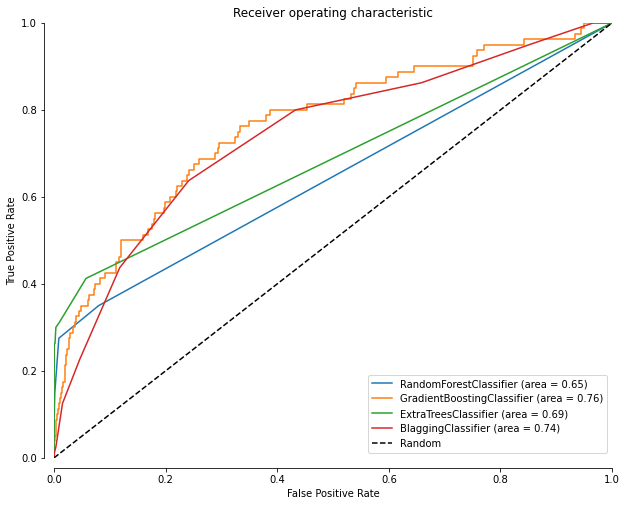

In [25]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for name, clf in clfs:
    
    clf.fit(X_train, y_train)
    fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    plt.plot(fpr, tpr, linestyle='-',
             label='{} (area = %0.2f)'.format(name) % roc_auc)
    
plt.plot([0, 1], [0, 1], linestyle='--', color='k',
         label='Random')    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')

plt.legend(loc="lower right")

plt.show()    

Видно, що за рахунок "завалювання прогнозів класифікатора в більший клас, градієнтний бустінг виграє в BlaggingClassifier'а.

Але давайте поглянемо на AUC-PR і повноту по рідкісному класу і все встане на свої місця.

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/forest.py:489: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use,

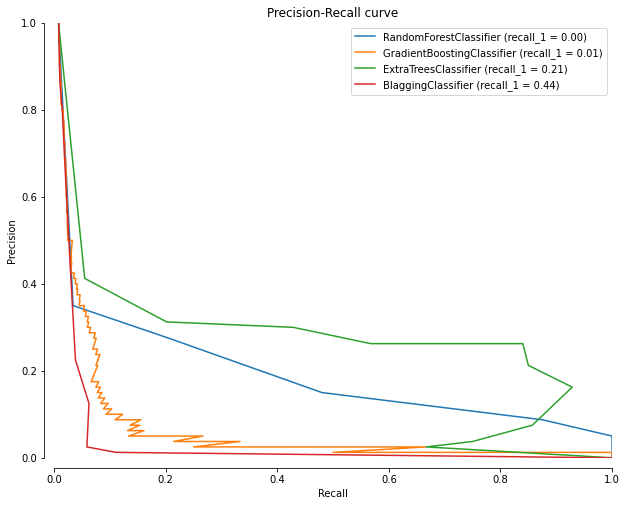

In [26]:
from sklearn.metrics import recall_score

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for name, clf in clfs:
    
    clf.fit(X_train, y_train)
    fpr, tpr, thresholds = precision_recall_curve(y_test, clf.predict_proba(X_test)[:, 1])
    recall_1 = recall_score(y_test, clf.predict(X_test))
    plt.plot(fpr, tpr, linestyle='-',
             label='{} (recall_1 = %0.2f)'.format(name) % recall_1)
    
    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')

plt.legend(loc="upper right")

plt.show()    

Тут ми бачимо, що найбільша `recall` меншого класу саме в Blagging Classifier'а.

## Библиотека imbalanced-learn

[Бібліотека](http://contrib.scikit-learn.org/imbalanced-learn/install.html) imbalanced-learn дозволяє використовувати різноманітні техніки семплювання (як over, так і under, а також їх комбінації). Позаду деяких технік стоять нетривіальні підходи, що не входять в даний туторіал, але я залишу посилання.

Бібліотека включає :

* Under-sampling methods. Все просто, семплюємо з більшого класу для вирівнювання вибірки по меншому класу. Можливі два варіанти: 
 - генерація нових прикладів з більшого класу на основі [центроїд](http://contrib.scikit-learn.org/imbalanced-  learn/generated/imblearn.under_sampling.ClusterCentroids.html) кластерів;
 - [вибірка](http://contrib.scikit-learn.org/imbalanced-learn/api.html#module-imblearn.under_sampling.prototype_selection) прикладів з більшого класу різними способами (їх досить багато)


* Over-sampling methods. Тут теж все просто -- ми додаємо в датасет приклади меншого класу, просто [копіюванням](http://contrib.scikit-learn.org/imbalanced-learn/generated/imblearn.over_sampling.RandomOverSampler.html) або використовуючи більш хитрі техніки як, наприклад, [SMOTE](http://contrib.scikit-learn.org/imbalanced-learn/generated/imblearn.over_sampling.SMOTE.html), який дозволяє генерувати синтетичні приклади на основі близькості декількох сусідів в ознаковому просторі, створюючи (с включенням випадковості) новий вектор ознак для нового прикладу. [Тут](https://www.cs.cmu.edu/afs/cs/project/jair/pub/volume16/chawla02a-html/node6.html#SECTION00042000000000000000) детальніше.

Давайте подивимося як поведуть себе ці методи на оригінальному датасеті за наявності всіх класів.

In [27]:
df = load_and_prepare_data()

X = df.drop('CLASS', axis=1).values
y = df.CLASS

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    test_size=0.4, random_state=RANDOM_STATE)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:395: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  check_array(X, dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_encoders.py:415: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".


In [28]:
df.CLASS.value_counts()

0    12493
1    10599
2     1206
3      513
4       93
5       54
6       36
7        6
9        5
8        5
Name: CLASS, dtype: int64

Почнемо з простого -- звичайний undersampling:

In [29]:
clf = ExtraTreesClassifier(random_state=RANDOM_STATE)

clf.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test)))

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/forest.py:489: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_store_unique_indices = np.zeros(y.shape, dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence t

              precision    recall  f1-score   support

           0       0.52      0.64      0.57      4997
           1       0.44      0.38      0.41      4240
           2       0.08      0.01      0.02       482
           3       0.00      0.00      0.00       205
           4       0.00      0.00      0.00        37
           5       0.80      0.55      0.65        22
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         3
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         2

    accuracy                           0.48     10004
   macro avg       0.18      0.16      0.16     10004
weighted avg       0.45      0.48      0.46     10004



/usr/local/lib/python3.7/dist-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  y_encoded = np.zeros(y.shape, dtype=np.int)
/usr/local/lib/python3.7/dist-packages/sklearn/tree/tree.py:163: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release 

Уже неплохо (5,6 и 7 классы), но мы сильно просели по большим классам.

Попробуем [CondensedNearestNeighbour](http://machinelearning.org/proceedings/icml2005/papers/004_Fast_Angiulli.pdf):

In [30]:
!pip install mlrose

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1310 sha256=4322b34728a9e179e9d209952b96b8878ca986de8e0d3bb0e39895aa44af2833
  Stored in directory: /root/.cache/pip/wheels/46/ef/c3/157e41f5ee1372d1be90b09f74f82b10e391eaacca8f22d33e
Successfully built sklearn


In [31]:
import six
import sys
sys.modules['sklearn.externals.six'] = six
import mlrose

In [38]:
!pip install scikit-learn==0.21.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 6.7 MB 5.6 MB/s 
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 0.24.1
    Uninstalling scikit-learn-0.24.1:
      Successfully uninstalled scikit-learn-0.24.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
yellowbrick 1.5 requires scikit-learn>=1.0.0, but you have scikit-learn 0.21.1 which is incompatible.
imbalanced-learn 0.9.0 requires scikit-learn>=1.0.1, but you have scikit-learn 0.21.1 which is incompatible.


In [39]:
from imblearn.under_sampling import CondensedNearestNeighbour, RandomUnderSampler
from imblearn.pipeline import make_pipeline

pipe = make_pipeline(CondensedNearestNeighbour(random_state=RANDOM_STATE), 
                     ExtraTreesClassifier(random_state=RANDOM_STATE))

pipe.fit(X_train, y_train)

print(classification_report(y_test, pipe.predict(X_test)))

ImportError: ignored

Вже краще, ми знову бачимо великі класи!

Варто відмітити, що багато з методів, доступних в imbalanced-learn не працюють для мультикласової постановки задачі. Тому повернемося до бінарної постановки для демонстрації підходу over-sampling.

In [ ]:
df = load_and_prepare_data()
binary_y = make_binary(df.CLASS, set((4, 5, 6, 7, 8, 9)))

print("After merging classes {0, 1, 2, 3} -> 0 and {4, 5, 6, 7, 8, 9} -> 1 \n")

np.unique(binary_y, return_counts=True)
X = df.drop('CLASS', axis=1).values
y = binary_y

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, 
                                                    test_size=0.4, random_state=RANDOM_STATE)

After merging classes {0, 1, 2, 3} -> 0 and {4, 5, 6, 7, 8, 9} -> 1 



In [ ]:
from imblearn.over_sampling import RandomOverSampler

pipe = make_pipeline(RandomOverSampler(random_state=RANDOM_STATE), 
                     ExtraTreesClassifier(random_state=RANDOM_STATE))

pipe.fit(X_train, y_train)

print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9924
           1       0.91      0.26      0.41        80

    accuracy                           0.99     10004
   macro avg       0.95      0.63      0.70     10004
weighted avg       0.99      0.99      0.99     10004



Навіть звичайний over-sampling справился непогано.

In [ ]:
from imblearn.over_sampling import SMOTE

pipe = make_pipeline(SMOTE(random_state=RANDOM_STATE), 
                     ExtraTreesClassifier(random_state=RANDOM_STATE))

pipe.fit(X_train, y_train)

print(classification_report(y_test, pipe.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00      9924
           1       0.85      0.28      0.42        80

    accuracy                           0.99     10004
   macro avg       0.92      0.64      0.71     10004
weighted avg       0.99      0.99      0.99     10004



Варто відмітити, що imblearn має свою функцію оцінки якості моделі, що включає precision, recall, specificity (true negative rate), f1, геометричне середнє recall (sensitivity) і specificity, а також index balanced [accuracy](http://repositori.uji.es/xmlui/bitstream/handle/10234/23961/33068.pdf?sequence=1).

Останній розраховується наступним чином:

$$ IBA = (1 + Dominance)· Gmean^2 ,$$
    де
$$ Dominance = True Positive Rate - True Negative Rate $$

In [ ]:
from imblearn.metrics import classification_report_imbalanced

print(classification_report_imbalanced(y_test, pipe.predict(X_test)))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.99      1.00      0.28      1.00      0.52      0.29      9924
          1       0.85      0.28      1.00      0.42      0.52      0.25        80

avg / total       0.99      0.99      0.28      0.99      0.52      0.29     10004



Наостанок побудуємо ROC-криві для деяких методів.

In [ ]:
class DummySampler(object):

    def fit(self, X, y):
        return self

    def fit_sample(self, X, y):
        return X, y 
    
    def fit_resample(self, X, y):
        return X, y 

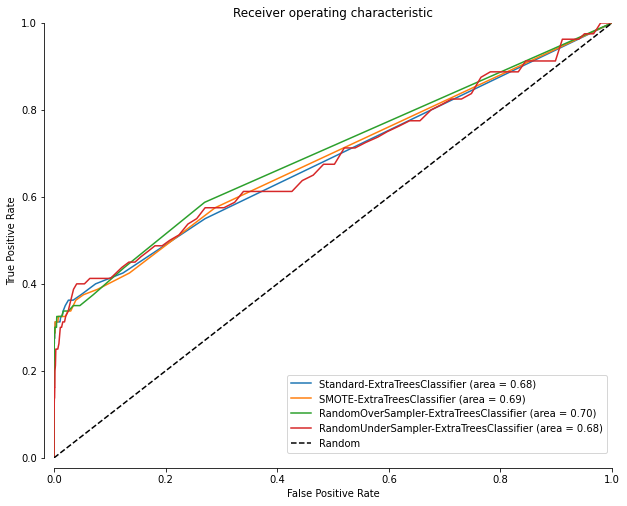

In [ ]:
classifier = ['ExtraTreesClassifier', ExtraTreesClassifier()]

samplers = [
    ['Standard',           DummySampler()],
    ['SMOTE',              SMOTE(random_state=RANDOM_STATE)],
    ['RandomOverSampler',  RandomOverSampler(random_state=RANDOM_STATE)],
    ['RandomUnderSampler', RandomUnderSampler(random_state=RANDOM_STATE)]
]

pipelines = [
    ['{}-{}'.format(sampler[0], classifier[0]),
     make_pipeline(sampler[1], classifier[1])]
    for sampler in samplers
]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for name, clf in pipelines:
    
    clf.fit(X_train, y_train)
    fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
    roc_auc = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    plt.plot(fpr, tpr, linestyle='-',
             label='{} (area = %0.2f)'.format(name) % roc_auc)
    
plt.plot([0, 1], [0, 1], linestyle='--', color='k',
         label='Random')    
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.get_xaxis().tick_bottom()
ax.get_yaxis().tick_left()
ax.spines['left'].set_position(('outward', 10))
ax.spines['bottom'].set_position(('outward', 10))
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')

plt.legend(loc="lower right")

plt.show()    